<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Diddier Cofré</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [ ]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [52]:
import os
import zipfile

zip_path = 'batch_june2024.zip' # La ruta del archivo zip
expected_folder = 'processed512' # El nombre de la carpeta al interior del archivo zip

In [54]:
# Detectar las clases existentes en la carpeta
folder = 'processed512/processed512'
clases_detectadas = set()

# Listar las clases existentes
for archivo in os.listdir(folder):
    if archivo.endswith('.png'):
        clase = archivo.split('_')[0]
        clases_detectadas.add(clase)

# Imprimir las clases existentes detectadas en la carpeta
print("Clases detectadas en la carpeta:")
print(clases_detectadas)


Clases detectadas en la carpeta:
{'cross', 'circ', 'box'}


In [59]:
import cv2
import matplotlib.pyplot as plt

clases = ['circ', 'cross', 'box']
folder = 'processed512/processed512'
ejemplos = {} # Diccionario para guardar un ejemplo de cada clase

# Se recorren las imagenes y se guarda un ejemplo de cada clase
for archivo in os.listdir(folder):
    for clase in clases:
        if archivo.startswith(clase) and clase not in ejemplos:
            ejemplos[clase] = archivo
    if len(ejemplos) == 3:
        break

# Se grafican los 3 ejemplos, 1 de cada clase
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, clase in enumerate(clases):
    path = os.path.join(folder, ejemplos[clase])
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # de BGR a RGB para una correcta visualización
    axs[i].imshow(img_rgb)
    axs[i].set_title(f"{clase}\n{ejemplos[clase]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show() # Mostarlas



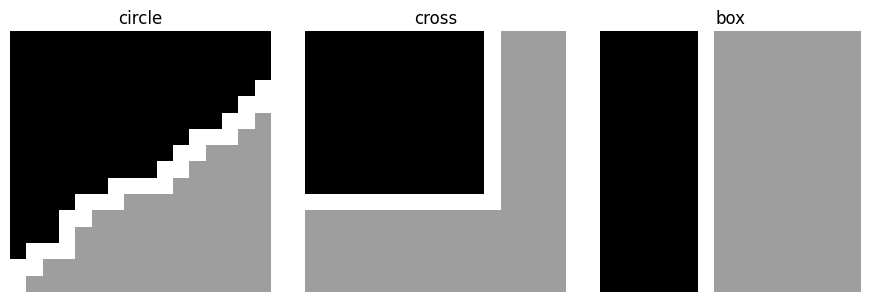

In [61]:
# Cargar los 3 templates en escala de grises
templates = {
    'circle': cv2.imread('circ_template.png', cv2.IMREAD_GRAYSCALE),
    'cross':  cv2.imread('cross_template.png',  cv2.IMREAD_GRAYSCALE),
    'box':    cv2.imread('box_template.png',    cv2.IMREAD_GRAYSCALE)
}

# Visualización
plt.figure(figsize=(9, 3))
for i, (label, tmpl) in enumerate(templates.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow(tmpl, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [62]:
import cv2
import numpy as np

# Preparamos la imagen para el matching
def preparar_imagen(imagen_color):

    # La convertimos a escala de grises
    gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

    # Se realiza un suavizado ligero para reducir el ruido
    suavizada = cv2.GaussianBlur(gris, (3, 3), 0)

    # Se realiza una normalización entre 0 y 1
    normalizada = suavizada.astype(np.float32) / 255.0

    return normalizada

In [63]:
# Ejemplo de preparación de imagen
path = "processed512/processed512/box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-0_80-90.png"
imagen = cv2.imread(path)
imagen_preparada = preparar_imagen(imagen)

plt.imshow(imagen_preparada, cmap='gray')
plt.title("Imagen preparada")
plt.axis('off')
plt.show()


## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [69]:
# Procesamiento de la imagen para prepararla para el matching
def procesar_imagen_para_matching(imagen_color):

    # Escala de grises
    gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

    # Suavizado
    suavizada = cv2.GaussianBlur(gris, (3, 3), 0)

    # Normalización
    normalizada = suavizada.astype(np.float32) / 255.0

    # Binarización adaptativa (mejor que umbral fijo en este contexto)
    binarizada = cv2.adaptiveThreshold((normalizada*255).astype(np.uint8),
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV,
                                       11, 2)
    return binarizada

In [72]:
# Ejemplo de procesamiento de la imagen
ejemplo_path = 'processed512/processed512/box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-0_80-90.png'
img = cv2.imread(ejemplo_path)

procesada = procesar_imagen_para_matching(img)

# Comparar la imagen original con la procesada

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(procesada, cmap='gray')
plt.title('Procesada para Matching')
plt.axis('off')
plt.tight_layout()
plt.show()


## 4.1 Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

![image.png](attachment:6850d57c-7e6f-4acf-ac3b-d9a8feb071cb.png)

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [ ]:
# Se aplica a las imagenes lo trabajado en los puntos 2. y 3. pero ahora para el matching
def pipeline_preprocesamiento(imagen_color):

    gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
    suavizada = cv2.GaussianBlur(gris, (3, 3), 0)
    normalizada = suavizada.astype(np.float32) / 255.0
    # Binarización adaptativa para resaltar patrones
    binarizada = cv2.adaptiveThreshold((normalizada * 255).astype(np.uint8),
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV,
                                       11, 2)
    return binarizada


In [73]:
import time
from tqdm import tqdm

# Ahora realizamos el matching (Se compara cada imagen con todas las clases y se retorna la clase que obtenga mayor correlación con la imagen)
def hacer_matching(imagen, templates):

    mejores_valores = {}
    for clase, template in templates.items():
        # Asegurar que el template esté en formato uint8 binario
        template_bin = cv2.adaptiveThreshold(template, 255,
                                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY_INV, 11, 2)

        resultado = cv2.matchTemplate(imagen, template_bin, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(resultado)
        mejores_valores[clase] = max_val

    # Retorna la clase con mayor correlación
    return max(mejores_valores, key=mejores_valores.get)

# Directorio de imágenes
folder = 'processed512/processed512'
clases = ['circ', 'cross', 'box']

# Para evaluar el rendimiento
total = 0
aciertos = 0
resultados = []

# Medir tiempo de ejecución
inicio = time.time()

for archivo in tqdm(os.listdir(folder)):
    if archivo.endswith('.png'):
        total += 1
        ruta = os.path.join(folder, archivo)
        imagen_color = cv2.imread(ruta)
        imagen_preparada = pipeline_preprocesamiento(imagen_color)

        predicha = hacer_matching(imagen_preparada, templates)

        # Extraer la clase verdadera desde el nombre del archivo
        real = archivo.split('_')[0]
        real = 'circle' if real == 'circ' else real  # Ajuste de nombre

        if predicha == real:
            aciertos += 1

        resultados.append((archivo, real, predicha))

fin = time.time()

100%|██████████| 14328/14328 [06:44<00:00, 35.43it/s]


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.



Ejemplos Correctos
box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-22_80-90.png - Real: box, Predicha: box


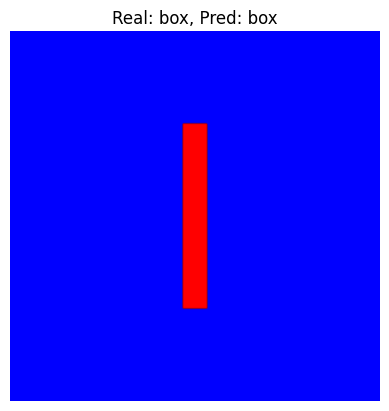

box_01_freq_reflect_e3744294-aba9-11ee-b4d0-047c16a08772_0-421_80-90.png - Real: box, Predicha: box



Ejemplos Incorrectos
cross_01_freq_reflect_3bb122d5-e627-11ee-9e43-a4c3f0508c4a_0-131_80-90.png - Real: cross, Predicha: box


cross_01_freq_reflect_bb139a98-e549-11ee-944e-047c16a08772_0-292_80-90.png - Real: cross, Predicha: box


In [75]:
# Separar ejemplos correctos e incorrectos
ejemplos_correctos = [r for r in resultados if r[1] == r[2]][:2]
ejemplos_erroneos = [r for r in resultados if r[1] != r[2]][:2]

# Se muestran 2 ejemplos correctos y 2 incorrectos
def mostrar_ejemplos(lista, titulo):
    print("\n" + titulo)
    for nombre, real, pred in lista:
        print(f"{nombre} - Real: {real}, Predicha: {pred}")
        img = cv2.imread(os.path.join(folder, nombre))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Real: {real}, Pred: {pred}")
        plt.axis('off')
        plt.show()

mostrar_ejemplos(ejemplos_correctos, "Ejemplos Correctos")
mostrar_ejemplos(ejemplos_erroneos, "Ejemplos Incorrectos")


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [78]:
# Se observan los resultados finales (La precisión (aciertos) y el tiempo de ejecución)
precision = aciertos / total
tiempo_total = fin - inicio

print(f"Total de imágenes: {total}")
print(f"Aciertos: {aciertos}")
print(f"Precisión: {precision:.4f}")
print(f"Tiempo total de procesamiento: {tiempo_total:.2f} segundos")

Total de imágenes: 14328
Aciertos: 3936
Precisión: 0.2747
Tiempo total de procesamiento: 404.39 segundos


## 7. Preprocesamiento y Matching optimizados

Veremos si es que logramos mejorar la precisión y reducir el tiempo de ejecución

In [82]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

FOLDER_IMAGENES = 'processed512/processed512'
FOLDER_TEMPLATES = 'processed512/processed512'  # Ajusta si el folder es otro
CLASES = ['circ', 'cross', 'box']
REDUCIR_RESOLUCION = True
RESOLUCION = (128, 128)  # Reducimos la resolución para un procesamiento mas rapido (antes era de 512x512)

# CARGA Y PREPROCESAMIENTO DE PLANTILLAS

def cargar_templates(folder, clases):
    templates = {}
    for clase in clases:
        for archivo in os.listdir(folder):
            if archivo.startswith(clase):
                path = os.path.join(folder, archivo)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if REDUCIR_RESOLUCION:
                    img = cv2.resize(img, (32, 32))  # Tamaño normalizado
                binarizada = cv2.adaptiveThreshold(img, 255,
                                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                   cv2.THRESH_BINARY_INV, 11, 2)
                templates[clase] = binarizada
                break
    return templates

# PREPROCESAMIENTO DE IMÁGENES

def pipeline_preprocesamiento(imagen_color):
    if REDUCIR_RESOLUCION:
        imagen_color = cv2.resize(imagen_color, RESOLUCION)

    gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
    suavizada = cv2.GaussianBlur(gris, (3, 3), 0)
    normalizada = suavizada.astype(np.float32) / 255.0

    binarizada = cv2.adaptiveThreshold((normalizada * 255).astype(np.uint8),
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV,
                                       11, 2)
    return binarizada

# MATCHING

def hacer_matching(imagen_binaria, templates):
    mejores_valores = {}
    for clase, template in templates.items():
        resultado = cv2.matchTemplate(imagen_binaria, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(resultado)
        mejores_valores[clase] = max_val
    return max(mejores_valores, key=mejores_valores.get)

# MAIN

def main():
    templates = cargar_templates(FOLDER_TEMPLATES, CLASES)

    total = 0
    aciertos = 0
    resultados = []

    inicio = time.time()

    for archivo in tqdm(os.listdir(FOLDER_IMAGENES)):
        if archivo.endswith('.png'):
            total += 1
            ruta = os.path.join(FOLDER_IMAGENES, archivo)
            imagen_color = cv2.imread(ruta)
            imagen_preparada = pipeline_preprocesamiento(imagen_color)
            predicha = hacer_matching(imagen_preparada, templates)

            real = archivo.split('_')[0]
            real = 'circle' if real == 'circ' else real  # Ajuste de nombre
            predicha = 'circle' if predicha == 'circ' else predicha

            if predicha == real:
                aciertos += 1

            resultados.append((archivo, real, predicha))

    fin = time.time()

# RESULTADOS

    precision = aciertos / total
    print(f"\n--- RESULTADOS ---")
    print(f"Total de imágenes: {total}")
    print(f"Aciertos: {aciertos}")
    print(f"Precisión: {precision:.4f}")
    print(f"Tiempo total de procesamiento: {fin - inicio:.2f} segundos")

    return resultados

# Ejecutarlo
resultados = main()

100%|██████████| 14328/14328 [01:30<00:00, 159.17it/s]


--- RESULTADOS ---
Total de imágenes: 14328
Aciertos: 4334
Precisión: 0.3025
Tiempo total de procesamiento: 90.03 segundos
